# Noisy GP Experiments

In [1]:
import numpy as np
import numba
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.utils import check_random_state, check_array, check_X_y
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import _check_length_scale, WhiteKernel, RBF, ConstantKernel as C
from scipy import interpolate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
mpl.rcParams['savefig.pad_inches'] = 0

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1D Toy Example

In [2]:
figure_location = '/home/emmanuel/projects/2018_igarss/figures/noisy_gp/1d_example/'
figure_location = '/Users/eman/Documents/code_projects/gaussian_processes/pkg_sgpuppy/figures/'
figure_location = '/home/emmanuel/projects/gaussian_processes/pkg_sgpuppy/figures/'

In [3]:
weights = {}
predictions = {}
variance = {}
mae = {}
mse = {}
rmse = {}

### Sample Data

In [4]:
seed = 123
rng = np.random.RandomState(seed=seed)

# sample data parameters
n_train, n_test, n_trial = 60, 100, 100
sigma_y = 0.05
x_cov = 0.3
y_scale = .5
x_min, x_max = -10, 10

# real function
f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + y_scale * x))
# f = lambda x: np.sinc(x)
# f = lambda x: np.sin(2. * x) + np.exp(0.2 * x)


# Training add x, y = f(x)
x = np.linspace(x_min, x_max, n_train + n_test + n_trial)


x, xs, = train_test_split(x, train_size=n_train, random_state=seed)

# add noise
y = f(x)
x_train = x + x_cov * rng.randn(n_train)
y_train = f(x) + sigma_y * rng.randn(n_train)

x_train, y_train = x_train[:, np.newaxis], y_train[:, np.newaxis]



# -----------------
# Testing Data
# -----------------
xs, xt = train_test_split(xs, train_size=n_test, random_state=seed)
xt = np.sort(xt)

ys = f(xs)

# Add noise
x_test = xs + x_cov * rng.randn(n_test)
y_test = ys

x_test, y_test = x_test[:, np.newaxis], y_test[:, np.newaxis]

# -------------------
# Plot Points
# -------------------
x_plot = np.linspace(x_min, x_max, n_test)[:, None]
y_plot = f(x_plot)

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, x_test.shape)

(60,) (60,)
(60, 1) (60, 1)
(100, 1) (100, 1)


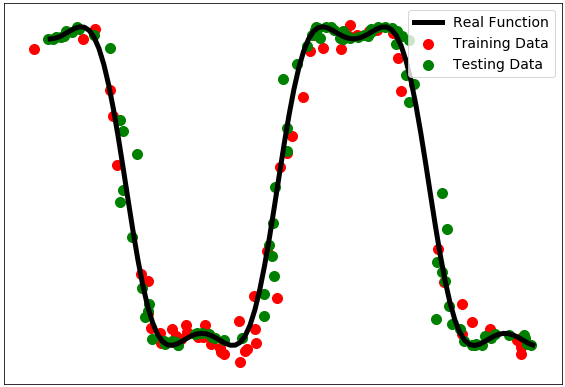

In [6]:
# plot toy data
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, y_plot, linewidth=5, color='k', label='Real Function')
ax.scatter(x_train, y_train, color='r', s=100, label='Training Data')
ax.scatter(x_test, y_test, color='g', s=100, label='Testing Data')

# ax.set_title('Training and Testing Data', fontsize=20)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'training_data.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Naive GP Implementation (to Find Suitable Hyperparameters)

In [7]:
def fit_gp(x_train, y_train, kernel='ard', scale=None,
           length_scale_bounds = (0.001, 100),
           noise_level_bounds = (1e-4, 10),
           n_restarts=3):
    
    warnings.simplefilter('ignore')
    x_train, y_train = check_X_y(x_train, y_train)
    warnings.simplefilter('default')
    n_train, d_dims = x_train.shape
    
    if kernel in ['ard', 'ARD']:
        length_scale_init = np.ones(shape=(d_dims))
    elif kernel in ['rbf', 'RBF']:
        length_scale_init = 1.0
    else:
        raise ValueError('Unrecognized kernel function...')
    
    noise_level_init = 1.0

    gp_kernel = C() * RBF(length_scale=length_scale_init,
                    length_scale_bounds=length_scale_bounds) + \
                WhiteKernel(noise_level=noise_level_init,
                            noise_level_bounds=noise_level_bounds)
    
    gpr_model = GaussianProcessRegressor(kernel=gp_kernel, random_state=123,
                                         n_restarts_optimizer=n_restarts)
    
    # Fit the GP Model
    gpr_model.fit(x_train, y_train)
    
    # the parameters
    
    constant = gpr_model.kernel_.get_params()['k1__k1__constant_value']
    length_scale = gpr_model.kernel_.get_params()['k1__k2__length_scale']
    sigma = gpr_model.kernel_.get_params()['k2__noise_level']
    
    return length_scale, sigma, constant

In [8]:
length_scale, sigma_y, constant = fit_gp(x_train, y_train, n_restarts=0)
print('Length Scale: {:.3f}'.format(length_scale))
print('Sigma y: {:.3f}'.format(sigma_y))
print('Likelihood Variance: {:.3f}'.format(constant))

Length Scale: 1.854
Sigma y: 0.013
Likelihood Variance: 0.656


## Gaussian Covariance Function (ARD/RBF Kernel)

\begin{equation}
    K(x, y) = \nu \cdot \text{exp} \left[ -\frac{1}{2} (x - y)^{\top} \cdot W^{-1} \cdot (x - y) \right]
\end{equation}

* $W^{-1}= \text{diag}\left[ w_1, w_2, \ldots, w_{D} \right]$
* $w_d = \frac{1}{\lambda_d^2}$
* $\nu$ is the signal variance parameter

### GP/KRR Manually

In [18]:
from GaussianProcess import GaussianProcess
from Covariance import GaussianCovariance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
w = np.array([length_scale])
v = constant
vt = sigma_y
Sigma = np.array([0.8])
if np.ndim(Sigma) == 1:
    Sigma = Sigma[:, np.newaxis]

# Preparing the parameter vector
theta = np.zeros(2+len(w))
theta[0] = np.log(v)  # We actually use the log of the parameters as it is easier to optimize (no > 0 constraint etc.)
theta[1] = np.log(vt)
theta[2:2+len(w)] = np.log(w)

# Simulating simulation data by drawing data from a random Gaussian process
t = GaussianProcess.get_realisation(x_train, GaussianCovariance(),theta)

# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x_train, y_train,GaussianCovariance());

[-0.44196361 -1.82825797 -4.62977644]
l_bfgs_b 	 0.0917501449584961 	 [[-14.67484715]] 	 [-0.37193111 -4.30782621 -1.25336646]
[-0.37193111 -4.30782621 -1.25336646]


In [20]:
%%time
# Initialize the GP and Fit the model
gp_model = GaussianProcess(x_train, y_train, GaussianCovariance());

# Predict
predictions['simple'], var = gp_model.estimate_many(x_test);

mae['simple'] = mean_absolute_error(predictions['simple'], y_test)
mse['simple'] = mean_squared_error(predictions['simple'], y_test)
rmse['simple'] = np.mean(np.sqrt(np.mean(predictions['simple'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['simple']))
print('MSE Score: {:.5f}'.format(mse['simple']))
print('RMSE Score: {:.5f}\n'.format(rmse['simple']))

[-0.44196361 -1.82825797 -4.62977644]
l_bfgs_b 	 0.09655451774597168 	 [[-14.67484715]] 	 [-0.37193111 -4.30782621 -1.25336646]
[-0.37193111 -4.30782621 -1.25336646]

MAE Score: 0.11215
MSE Score: 0.02983
RMSE Score: 0.11215

CPU times: user 478 ms, sys: 2.84 s, total: 3.32 s
Wall time: 106 ms


#### Plot Simple GP Results

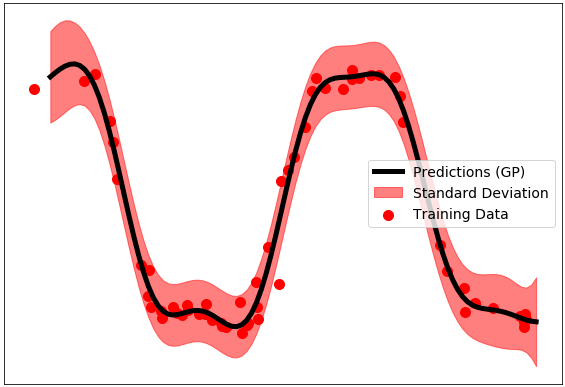

In [39]:
# Get Figure for x_plot
predictions['simple'], variance['simple'] = gp_model.estimate_many(x_plot)


# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['simple'], linewidth=5, color='k', label='Predictions (GP)')
ax.fill_between(x_plot.squeeze(), 
                predictions['simple'].squeeze() - 2*np.sqrt(variance['simple']).squeeze(),
                predictions['simple'].squeeze() + 2*np.sqrt(variance['simple']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_simple.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Uncertainty Propagation (Approximate)

In [40]:
from UncertaintyPropagation import UncertaintyPropagationApprox

In [43]:
%%time 

# Initialize GP
gp_approx = UncertaintyPropagationApprox(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['approx'] = np.zeros(n_samples)
var = np.zeros(n_samples)
print(x_test.shape)
for i in range(n_samples):
    predictions['approx'][i], var[i] = gp_approx.propagate_GA(x_test[i],Sigma)

mae['approx'] = mean_absolute_error(predictions['approx'], y_test)
mse['approx'] = mean_squared_error(predictions['approx'], y_test)
rmse['approx'] = np.mean(np.sqrt(np.mean(predictions['approx'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['approx']))
print('MSE Score: {:.5f}'.format(mse['approx']))
print('RMSE Score: {:.5f}\n'.format(rmse['approx']))

print(var.min(), var.max())

(100, 1)

MAE Score: 0.18766
MSE Score: 0.05959
RMSE Score: 0.80787

0.015284983210722691 0.6285197557966403
CPU times: user 4.3 s, sys: 60.1 ms, total: 4.36 s
Wall time: 4.35 s


##### Plot Derivative Term Results

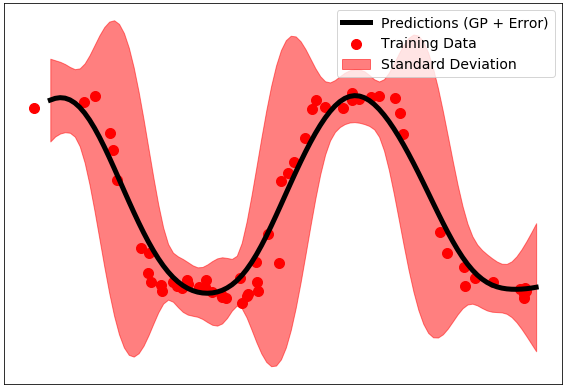

In [44]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['approx'] = np.zeros(n_samples)
variance['approx'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['approx'][i], variance['approx'][i] = gp_approx.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['approx'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['approx'].squeeze() - 2*np.sqrt(variance['approx']).squeeze(),
                predictions['approx'].squeeze() + 2*np.sqrt(variance['approx']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_approx.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Exact Uncertainty

In [45]:
from UncertaintyPropagation import UncertaintyPropagationExact

In [47]:
%%time
# Initialize GP
gp_exact = UncertaintyPropagationExact(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['exact'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['exact'][i], var[i] = gp_exact.propagate_GA(x_test[i],Sigma)
    
mae['exact'] = mean_absolute_error(predictions['exact'], y_test)
mse['exact'] = mean_squared_error(predictions['exact'], y_test)
rmse['exact'] = np.mean(np.sqrt(np.mean(predictions['exact'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['exact']))
print('MSE Score: {:.5f}'.format(mse['exact']))
print('RMSE Score: {:.5f}\n'.format(rmse['exact']))
print(var.min(), var.max())


MAE Score: 0.16662
MSE Score: 0.04913
RMSE Score: 0.80781

0.019294667862848225 0.36629936589818823
CPU times: user 4.82 s, sys: 119 ms, total: 4.94 s
Wall time: 4.84 s


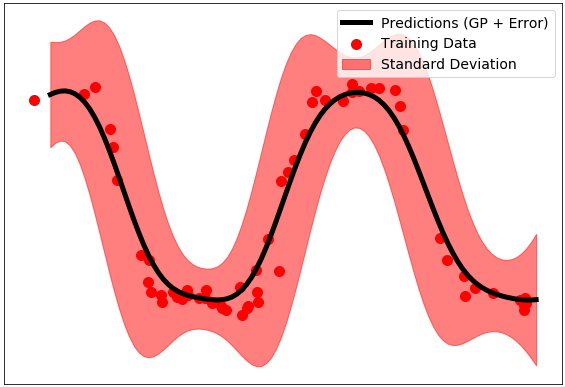

In [48]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['exact'] = np.zeros(n_samples)
variance['exact'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['exact'][i], variance['exact'][i] = gp_exact.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['exact'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['exact'].squeeze() - 2*np.sqrt(variance['exact']).squeeze(),
                predictions['exact'].squeeze() + 2*np.sqrt(variance['exact']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_exact.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Exact Numerical Uncertainty MCMC

In [49]:
from UncertaintyPropagation import UncertaintyPropagationMC

In [50]:
%%time
# Initialize GP
gp_stat = UncertaintyPropagationMC(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['stat'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['stat'][i], var[i] = gp_stat.propagate_GA(x_test[i],Sigma)
    
mae['stat'] = mean_absolute_error(predictions['stat'], y_test)
mse['stat'] = mean_squared_error(predictions['stat'], y_test)
rmse['stat'] = np.mean(np.sqrt(np.mean(predictions['stat'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['stat']))
print('MSE Score: {:.5f}'.format(mse['stat']))
print('RMSE Score: {:.5f}\n'.format(rmse['stat']))

print(var.min(), var.max())


MAE Score: 0.16529
MSE Score: 0.04861
RMSE Score: 0.80781

0.013551970045903805 0.37502451279481397
CPU times: user 32.9 s, sys: 342 ms, total: 33.3 s
Wall time: 33.3 s


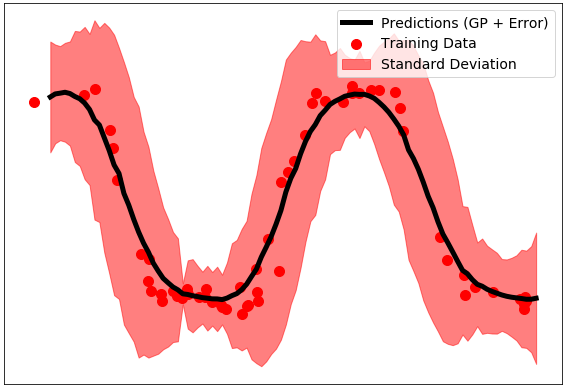

In [23]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['stat'] = np.zeros(n_samples)
variance['stat'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['stat'][i], variance['stat'][i] = gp_stat.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['stat'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['stat'].squeeze() - 2*np.sqrt(variance['stat']).squeeze(),
                predictions['stat'].squeeze() + 2*np.sqrt(variance['stat']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_stat.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Numerical

In [51]:
from UncertaintyPropagation import UncertaintyPropagationNumericalHG

In [52]:
%%time
# Initialize GP
gp_numerical = UncertaintyPropagationNumericalHG(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['numerical'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['numerical'][i], var[i] = gp_numerical.propagate_GA(x_test[i],Sigma)
    
mae['numerical'] = mean_absolute_error(predictions['numerical'], y_test)
mse['numerical'] = mean_squared_error(predictions['numerical'], y_test)
rmse['numerical'] = np.mean(np.sqrt(np.mean(predictions['numerical'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['numerical']))
print('MSE Score: {:.5f}'.format(mse['numerical']))
print('RMSE Score: {:.5f}\n'.format(rmse['numerical']))
print(var.min(), var.max())


MAE Score: 0.16682
MSE Score: 0.04925
RMSE Score: 0.80781

0.01748124606422652 0.37874630878991117
CPU times: user 385 ms, sys: 1.66 ms, total: 387 ms
Wall time: 384 ms


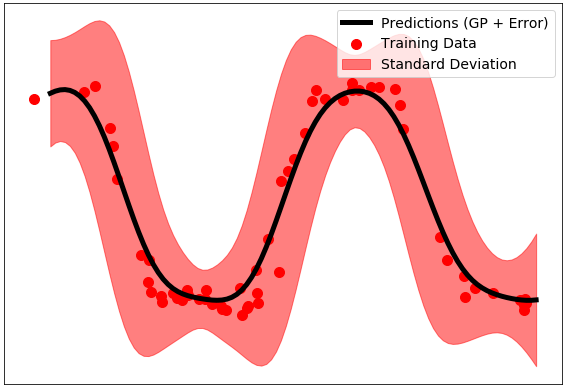

In [53]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['numerical'] = np.zeros(n_samples)
variance['numerical'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['numerical'][i], variance['numerical'][i] = gp_numerical.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['numerical'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['numerical'].squeeze() - 2*np.sqrt(variance['numerical']).squeeze(),
                predictions['numerical'].squeeze() + 2*np.sqrt(variance['numerical']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_numerical.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Empirical Variance Comparison


### Calculate the Empirical Variance (Get Scores)

In [54]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error
rng = np.random.RandomState(None)
n_trials = 20

mae_score = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

mse_score = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

abs_error = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}
squared_error = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

# testing set (noise-less)
ys = f(xt)
y_test = ys.squeeze()
y_test = np.atleast_2d(y_test).T
xt
# fig, ax = plt.subplots()


for itrial in range(n_trials):
    
    # Generate x samples with random error
    x_test = xt + 0.3 * rng.randn(n_trial)
    x_test = x_test[:, np.newaxis]
    n_samples = len(x_test)
#     ax.scatter(x_test, y_test)

    
    # -------------------
    # Model I - Simple GP
    # -------------------
    mean, _ = gp_model.estimate_many(x_test)
    
    abs_error['simple'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['simple'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['simple'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['simple'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))
    
    # -------------------
    # Model II - Approx
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_approx.propagate_GA(x_test[i],Sigma)
    
    abs_error['approx'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['approx'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['approx'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['approx'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))

    # -------------------
    # Model III - Exact
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_exact.propagate_GA(x_test[i],Sigma)
    
    abs_error['exact'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['exact'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['exact'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['exact'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))   

    # -------------------
    # Model IV - Numerical
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_stat.propagate_GA(x_test[i],Sigma)
    
    abs_error['stat'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['stat'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['stat'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['stat'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))

    # -------------------
    # Model IV - Numerical
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_numerical.propagate_GA(x_test[i],Sigma)
    
    abs_error['numerical'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['numerical'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['numerical'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['numerical'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))


CPU times: user 13min 44s, sys: 1.91 s, total: 13min 45s
Wall time: 13min 44s


In [55]:
abs_error['simple'] = np.mean(np.array(abs_error['simple']).squeeze(), axis=0)
squared_error['simple'] = np.mean(np.array(squared_error['simple']).squeeze(), axis=0)
mae_score['simple'] = np.mean(np.array(mae_score['simple']))
mse_score['simple'] = np.mean(np.array(mse_score['simple']))

abs_error['approx'] = np.mean(np.array(abs_error['approx']).squeeze(), axis=0)
squared_error['approx'] = np.mean(np.array(squared_error['approx']).squeeze(), axis=0)
mae_score['approx'] = np.mean(np.array(mae_score['approx']))
mse_score['approx'] = np.mean(np.array(mse_score['approx']))

abs_error['exact'] = np.mean(np.array(abs_error['exact']).squeeze(), axis=0)
squared_error['exact'] = np.mean(np.array(squared_error['exact']).squeeze(), axis=0)
mae_score['exact'] = np.mean(np.array(mae_score['exact']))
mse_score['exact'] = np.mean(np.array(mse_score['exact']))

abs_error['stat'] = np.mean(np.array(abs_error['stat']).squeeze(), axis=0)
squared_error['stat'] = np.mean(np.array(squared_error['stat']).squeeze(), axis=0)
mae_score['stat'] = np.mean(np.array(mae_score['stat']))
mse_score['stat'] = np.mean(np.array(mse_score['stat']))
                       
abs_error['numerical'] = np.mean(np.array(abs_error['numerical']).squeeze(), axis=0)
squared_error['numerical'] = np.mean(np.array(squared_error['numerical']).squeeze(), axis=0)
mae_score['numerical'] = np.mean(np.array(mae_score['numerical']))
mse_score['numerical'] = np.mean(np.array(mse_score['numerical']))

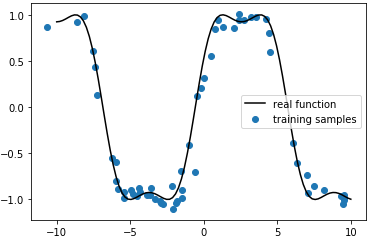

In [56]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, label='training samples')
ax.plot(x_plot, f(x_plot), color='black', label='real function')
ax.legend()
plt.show()
# ax.scatter(xs, abs_error['simple'], color='green', label='Empirical Absolute Error (Points)')

### No Uncertainty

MSE: 0.02811
MAE: 0.11080


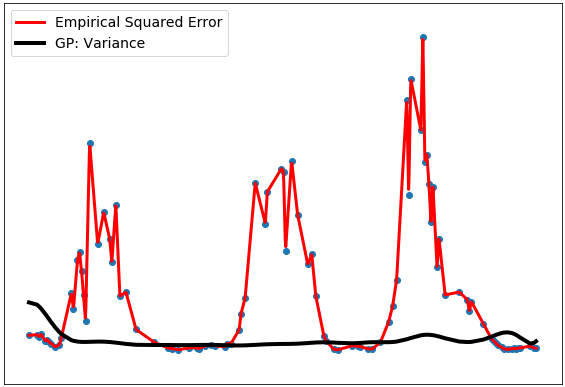

In [67]:
xnew = np.linspace(xt.min(), xt.max(), 1000)


# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['simple'], kind='slinear')(xnew)

print('MSE: {:.5f}'.format(mse_score['simple']))
print('MAE: {:.5f}'.format(mae_score['simple']))

pred, var = gp_model.estimate_many(xt[:, np.newaxis])

# pred, var = gp_simple.predict(xt[:, np.newaxis], return_variance=True)

fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.scatter(xt, squared_error['simple'])
ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var-0.013, linewidth=4, color='k', label='GP: Variance')

# ax.set_title('Squared Error, Variance')
ax.grid(True)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'exp_empirical_simple_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)




## Approximate Uncertainty

MSE: 0.04840
MAE: 0.16262


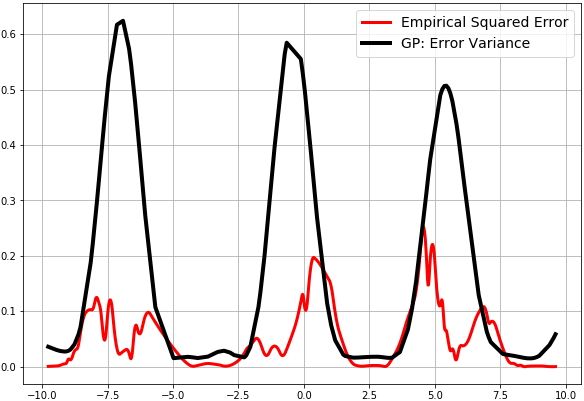

In [58]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['approx'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['approx'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_approx.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['approx']))
print('MAE: {:.5f}'.format(mae_score['approx']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var-0.013, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_approx_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Exact Uncertainty

MSE: 0.04036
MAE: 0.14479


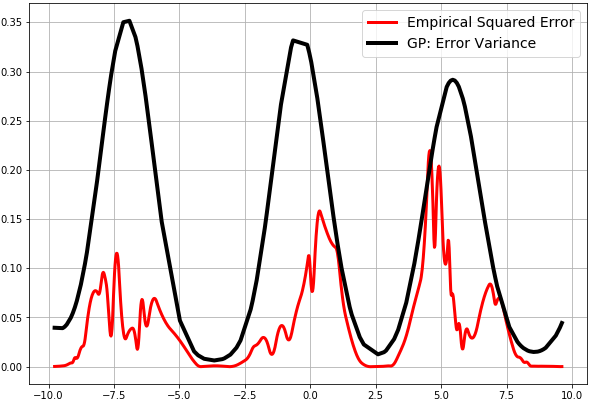

In [76]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['exact'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['exact'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_exact.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['exact']))
print('MAE: {:.5f}'.format(mae_score['exact']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var-0.013, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_exact_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


## Numcerical Uncertainty (MC)

In [ ]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['stat'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['stat'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_stat.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['stat']))
print('MAE: {:.5f}'.format(mae_score['stat']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var-0.013, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_stat_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Numerical Uncertainty

In [ ]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['numerical'], kind='linear')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['numerical'], kind='linear')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_numerical.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['numerical']))
print('MAE: {:.5f}'.format(mae_score['numerical']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var-0.013, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_numerical_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Q Matrix Optimization

In [276]:
xtrain = np.array([1, 5, 3])[:, np.newaxis]
xtest = np.array([1])[:, np.newaxis]
print(xtrain.shape, xtest.shape)
n_samples = xtrain.shape[0]
d_dimensions = xtrain.shape[1]

(3, 1) (1, 1)


In [216]:
xrow = xtrain[:, np.newaxis, :]
xrow = np.tile(xrow, [1, n_samples, d_dimensions])
print(xrow)
print(xrow.shape)

[[[1]
  [1]
  [1]]

 [[5]
  [5]
  [5]]

 [[3]
  [3]
  [3]]]
(3, 3, 1)


In [217]:
def zterm_matrix(xtrain):
    n_samples, d_dimensions = xtrain.shape
    
    xrow = xtrain[:, np.newaxis, :]
    xrow = np.tile(xrow, [1, n_samples, d_dimensions])
    zterm = 0.5 * (xrow + np.transpose(xrow, axes=(1,0, 2)))
    return zterm

In [94]:
xcol = xrow.copy() #xtrain[:, np.newaxis, :]
xcol = np.transpose(xcol, axes=(1,0, 2))
print(xcol)
print(xcol.shape)



[[[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]]
(3, 3, 1)


In [95]:
zterm = 0.5 * (xrow + xcol)
zterm = zterm_matrix(xtrain)
print(zterm == zterm2)
print(zterm.shape)

NameError: name 'zterm2' is not defined

In [91]:
zterm = zterm_matrix(xtrain)
zterm = zterm - xtest
print(zterm.shape, zterm.T.shape)

(3, 3, 1) (1, 3, 3)


In [95]:
diag_term = np.array([1.0])
print(zterm.shape, diag_term.shape)
exp_term = zterm.dot(diag_term).dot(zterm.T)
print(exp_term.shape)

(3, 3, 1) (1,)
(3, 1, 3)
